In [1]:
# autoreload external modules
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import conv

BATCH_SIZE = 256

# import CIFAR10 dataset (code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# one hot encoding of labels
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
#dataiter = iter(trainloader)
#images, labels = next(dataiter)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

## Now, we may want to create a validation set to properly do model selection

Our validation set will be taken from the TR set

In [2]:
# split the dataset into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# create data loaders for training and validation sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE)

In [3]:
len(trainloader.dataset.indices), len(valloader.dataset.indices)

(40000, 10000)

## First try, vanilla CNN with two convolutional layers

In [5]:
class ConvNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 4)
        self.conv2 = nn.Conv2d(8, 16, 4)
        self.conv3 = nn.Conv2d(16, 32, 4)
        self.conv4 = nn.Conv2d(32, 64, 4)
        self.conv5 = nn.Conv2d(64, 128, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    
    def convLayer(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        return x
    
    def mlpLayer(self, x):
        # sequential
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    

    def forward(self, x):
        x = self.convLayer(x)
        x = self.mlpLayer(x)
        return x

In [6]:
model = conv.ConvNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
history = []

for i in range(1, 30):
    h = conv.train(model, 'mps', trainloader, optimizer, criterion, i, val_loader=valloader)
    history.append(h)

KeyboardInterrupt: 

In [7]:
# create dataframe from history
df = pd.DataFrame(history, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
df.head()

,epoch,train_loss,train_acc,val_loss,val_acc


Text(0.5, 1.0, 'Accuracy')

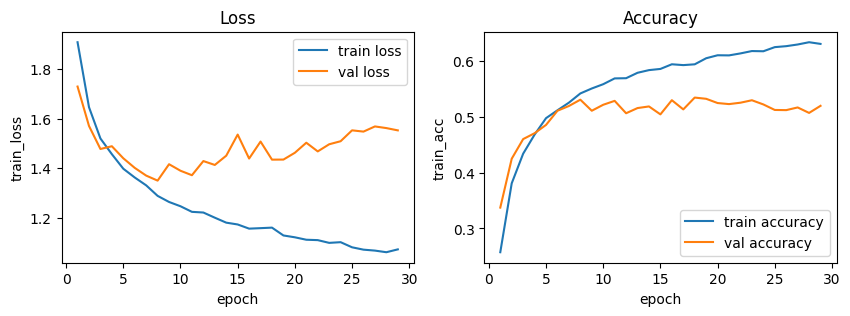

In [ ]:
# plot loss and accuracy with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x='epoch', y='train_loss', data=df, ax=axs[0], label='train loss')
sns.lineplot(x='epoch', y='val_loss', data=df, ax=axs[0], label='val loss')
axs[0].set_title('Loss')

sns.lineplot(x='epoch', y='train_acc', data=df, ax=axs[1], label='train accuracy')
sns.lineplot(x='epoch', y='val_acc', data=df, ax=axs[1], label='val accuracy')
axs[1].set_title('Accuracy')


### Trying add one more convolutional layer

In [16]:
class ConvNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, 4, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.conv5 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 10)

        self.dropout = nn.Dropout(0.25)

    def convLayer(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x) 
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        return x
    
    def mlpLayer(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x
    
    def forward(self, x):
        x = self.convLayer(x)
        x = self.mlpLayer(x)
        return x

In [20]:
# create model, loss function and optimizer
model = ConvNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
history = []

In [23]:
for i in range(1, 60):
    h = conv.train(model, 'mps', trainloader, optimizer, criterion, i, val_loader=valloader)
    history.append(h)

Epoch    1     | Training Loss: 0.778246     | Training Accuracy: 0.733850     | Validation Loss: 0.740830     | Validation Accuracy: 0.745000
Epoch    2     | Training Loss: 0.783129     | Training Accuracy: 0.734425     | Validation Loss: 0.739100     | Validation Accuracy: 0.746600
Epoch    3     | Training Loss: 0.780025     | Training Accuracy: 0.734900     | Validation Loss: 0.734843     | Validation Accuracy: 0.739200
Epoch    4     | Training Loss: 0.784975     | Training Accuracy: 0.734425     | Validation Loss: 0.712596     | Validation Accuracy: 0.753200
Epoch    5     | Training Loss: 0.768950     | Training Accuracy: 0.740875     | Validation Loss: 0.714821     | Validation Accuracy: 0.749700
Epoch    6     | Training Loss: 0.773477     | Training Accuracy: 0.734850     | Validation Loss: 0.730242     | Validation Accuracy: 0.747900
Epoch    7     | Training Loss: 0.772879     | Training Accuracy: 0.735900     | Validation Loss: 0.711928     | Validation Accuracy: 0.753500

KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy')

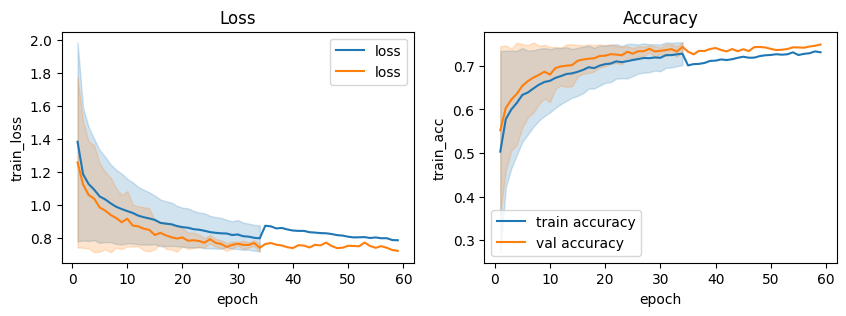

In [24]:
# create dataframe from history
df = pd.DataFrame(history, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
df.head()

# plot loss and accuracy with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x='epoch', y='train_loss', data=df, ax=axs[0], label='loss')
sns.lineplot(x='epoch', y='val_loss', data=df, ax=axs[0], label='loss')
axs[0].set_title('Loss')

sns.lineplot(x='epoch', y='train_acc', data=df, ax=axs[1], label='train accuracy')
sns.lineplot(x='epoch', y='val_acc', data=df, ax=axs[1], label='val accuracy')
axs[1].set_title('Accuracy')